## Setup

In [1]:
from modules.quicklook.src.analyze_time_series import AnalyzeTimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime
%matplotlib inline

import sqlite3

In [2]:
# files stored locally at /data/user/jspencermorris/testdata
db_path = '/testdata/kpf_ts_oct2024_v2.db' # name of database file

# import the test timeseries database
myTS = AnalyzeTimeSeries(db_path=db_path)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /testdata/kpf_ts_oct2024_v2.db
INFO: Base data directory: /data/L0
INFO: Primary table 'kpfdb' created/updated successfully.
INFO: Metadata table 'kpfdb_metadata' created/updated successfully.
INFO: Summary: 14928 obs x 1188 cols over 28 days in 1013KP.2-20241027; updated 2025-02-06 18:56:34


## Define Helper Functions

### Data acquisition

In [3]:
# define a function to return the column names from the timeseries database
def get_column_names(db_path, table_name='kpfdb', show_schema='no'):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute(f"PRAGMA table_info('{table_name}');")
    columns_info = cursor.fetchall()
    
    col_names = [col[1] for col in columns_info] # extract column names from the column information
    if show_schema.lower() == 'yes':
        print(f"Schema of {table_name}:")
        for i, col in enumerate(columns_info):
            print(f"{i}: {col[1]}")
        print("\n")  # Print a newline for better separation
    
    conn.close()
    
    return col_names

In [4]:
# define a function to run a query and return the results as a dataframe
def jsm_kpf_query(jsm_query):
    conn = sqlite3.connect(myTS.db_path)
    cursor = conn.cursor()
    query = jsm_query
    results_df = pd.read_sql_query(query, conn)
    conn.close()
    
    return results_df 

In [5]:
# define a function to perform filtering based on qc flags
def filter_qc(df, mode=None):
    if mode == None:
        return df
    elif mode == 'basic_relaxed':
        return df[
            (df['NOTJUNK'] != 0) & 
            (df['GOODREAD'] != 0) # currently, all values are None
        ]
    elif mode == 'basic_strict':
        return df[
            (df['NOTJUNK'] == 1) & 
            (df['GOODREAD'] == 1)
        ]
    elif mode == 'all_relaxed':
        return df[
            (df['NOTJUNK'] != 0) & 
            (df['GOODREAD'] != 0) & 
            (df['EMSAT'] != 0) & 
            (df['EMNEG'] != 0) & 
            (df['LOWBIAS'] != 0) & 
            (df['LOWDARK'] != 0) & 
            (df['LFC2DFOK'] != 0) & 
            (df['OLDBIAS'] != 0) & 
            (df['OLDDARK'] != 0) & 
            (df['OLDFLAT'] != 0) &
            #(df['FFFB'] != 'No') & # nearly all records are "No"
            #(df['EXPMETER'] != 'NO') & # nearly all records are "NO"
            (df['GREEN'] != 'NO')
        ]
    elif mode == 'all_strict':
        return df[
            (df['NOTJUNK'] == 1) & 
            (df['GOODREAD'] == 1) & 
            (df['EMSAT'] == 1) & 
            (df['EMNEG'] == 1) & 
            (df['LOWBIAS'] == 1) & 
            (df['LOWDARK'] == 1) & 
            (df['LFC2DFOK'] == 1) & 
            (df['OLDBIAS'] == 1) & 
            (df['OLDDARK'] == 1) & 
            (df['OLDFLAT'] == 1) &
            #(df['FFFB'] == 'Yes') & # nearly all records are "No"
            #(df['EXPMETER'] == 'YES') & # nearly all records are "NO"
            (df['GREEN'] == 'YES')
        ]
    else:
        raise ValueError("invalid mode specified")

### Plots

In [6]:
# define a function to plot the distributions of radial velocity values
def plot_rv_value_histograms_by_fiber(df):

    plt.figure(figsize=(10, 6))

    plt.hist(df['CCD1RV1'].dropna(), bins=50, alpha=0.5, label='CCD1RV1', color='purple', density=True)
    plt.hist(df['CCD1RV2'].dropna(), bins=50, alpha=0.5, label='CCD1RV2', color='green', density=True)
    plt.hist(df['CCD1RV3'].dropna(), bins=50, alpha=0.5, label='CCD1RV3', color='red', density=True)
    plt.hist(df['CCD1RV'].dropna(), bins=50, alpha=0.5, label='CCD1RV', color='black', density=True)

    plt.xlabel('RV (km/s)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Radial Velocity Values')
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
# define a function to plot the distributions of radial velocity errors
def plot_rv_error_histograms_by_fiber(df):

    plt.figure(figsize=(10, 6))

    plt.hist(df['CCD1ERV1'].dropna()*1000, bins=50, alpha=0.5, label='CCD1ERV1', color='purple', density=True)
    plt.hist(df['CCD1ERV2'].dropna()*1000, bins=50, alpha=0.5, label='CCD1ERV2', color='green', density=True)
    plt.hist(df['CCD1ERV3'].dropna()*1000, bins=50, alpha=0.5, label='CCD1ERV3', color='red', density=True)
    plt.hist(df['CCD1ERV'].dropna()*1000, bins=50, alpha=0.5, label='CCD1ERV', color='black', density=True)

    plt.xlabel('RV Error (m/s)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Radial Velocity Errors')
    plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
# define a function to make a Scatter plot of RV values and RV errors, for each fiber in CCD1
def plot_rv_error_scatter_by_fiber(df, xmin, xmax, ymin, ymax):

    plt.figure(figsize=(10, 6))
    plt.scatter(df['CCD1RV'], df['CCD1ERV']*1000, color='black', label='CCD1-Mean', alpha=0.5)
    plt.scatter(df['CCD1RV1'], df['CCD1ERV1']*1000, color='purple', label='CCD1ER1', alpha=0.5)
    plt.scatter(df['CCD1RV2'], df['CCD1ERV2']*1000, color='green', label='CCD1ER2', alpha=0.5)
    plt.scatter(df['CCD1RV3'], df['CCD1ERV3']*1000, color='red', label='CCD1ER3', alpha=0.5)

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.xlabel('RV (km/s)')
    plt.ylabel('Error in RV (m/s)')
    plt.title('Correlation Between CCD1 Radial Velocity Values and Errors, by Fiber')
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
# define a function to plot the RV values, along with their errors, from the Green CCD over time
def plot_rv_time_trends_grid(df, xmin, xmax, ymin, ymax):
    
    # make figure and axes grid
    fig, axs = plt.subplots(3, 3, figsize=(15, 9))  # 3 rows, 2 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing

    # plot at (0, 0)
    axs[0].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black', linewidth=4)
    axs[0].plot(df['day_num'], df['CCD1RV1'], label='CCD1RV1', color='purple')
    axs[0].plot(df['day_num'], df['CCD1RV2'], label='CCD1RV2', color='green')
    axs[0].plot(df['day_num'], df['CCD1RV3'], label='CCD1RV3', color='red')
    axs[0].set_xlabel('Day Number')
    axs[0].set_ylabel('Radial Velocity (km/s)')
    axs[0].set_title('CCD1 Radial Velocities Over Time')
    axs[0].legend()
    axs[0].grid(True)

    # plot at (0, 1)
    axs[1].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black', linewidth=4)
    axs[1].plot(df['day_num'], df['CCD1RV1'], label='CCD1RV1', color='purple')
    axs[1].plot(df['day_num'], df['CCD1RV2'], label='CCD1RV2', color='green')
    axs[1].plot(df['day_num'], df['CCD1RV3'], label='CCD1RV3', color='red')
    axs[1].set_xlim(0, 4)
    #axs[1].set_ylim(-150, 150)
    axs[1].set_xlabel('Day Number')
    axs[1].set_ylabel('Radial Velocity (km/s)')
    axs[1].set_title('CCD1 Radial Velocities Over Time')
    axs[1].legend()
    axs[1].grid(True)

    # plot at (0, 2)
    axs[2].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black', linewidth=4)
    axs[2].plot(df['day_num'], df['CCD1RV1'], label='CCD1RV1', color='purple')
    axs[2].plot(df['day_num'], df['CCD1RV2'], label='CCD1RV2', color='green')
    axs[2].plot(df['day_num'], df['CCD1RV3'], label='CCD1RV3', color='red')
    axs[2].set_xlim(xmin, xmax)
    axs[2].set_ylim(ymin, ymax)
    axs[2].set_xlabel('Day Number')
    axs[2].set_ylabel('Radial Velocity (km/s)')
    axs[2].set_title('CCD1 Radial Velocities Over Time')
    axs[2].legend()
    axs[2].grid(True)
    
    # compute the upper and lower bounds for the error region
    df['CCD1RV_upper'] = df['CCD1RV'] + df['CCD1ERV']
    df['CCD1RV_lower'] = df['CCD1RV'] - df['CCD1ERV']

    # plot at (1,0)
    axs[3].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black')
    axs[3].fill_between(df['day_num'], df['CCD1RV_lower'], df['CCD1RV_upper'], color='black', alpha=0.3, label='Error (CCD1ERV)')
    axs[3].set_xlabel('Day Number')
    axs[3].set_ylabel('CCD1RV Value')
    axs[3].set_title('CCD1RV Over Time with Error Shading')
    axs[3].legend()
    axs[3].grid(True)
    
    # plot at (1,1)
    axs[4].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black')
    axs[4].fill_between(df['day_num'], df['CCD1RV_lower'], df['CCD1RV_upper'], color='black', alpha=0.3, label='Error (CCD1ERV)')
    axs[4].set_xlim(0, 4)
    #axs[4].set_ylim(-150, 150)
    axs[4].set_xlabel('Day Number')
    axs[4].set_ylabel('CCD1RV Value')
    axs[4].set_title('CCD1RV Over Time with Error Shading')
    axs[4].legend()
    axs[4].grid(True)

    # plot at (1,2)
    axs[5].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black')
    axs[5].fill_between(df['day_num'], df['CCD1RV_lower'], df['CCD1RV_upper'], color='black', alpha=0.3, label='Error (CCD1ERV)')
    axs[5].set_xlim(xmin, xmax)
    axs[5].set_ylim(ymin, ymax)
    axs[5].set_xlabel('Day Number')
    axs[5].set_ylabel('CCD1RV Value')
    axs[5].set_title('CCD1RV Over Time with Error Shading')
    axs[5].legend()
    axs[5].grid(True)

    # plot at (2,0)
    axs[6].plot(df['day_num'], df['CCD1ERV'], label='CCD1ERV', color='black', linewidth=4)
    axs[6].plot(df['day_num'], df['CCD1ERV1'], label='CCD1ERV1', color='purple')
    axs[6].plot(df['day_num'], df['CCD1ERV2'], label='CCD1ERV2', color='green')
    axs[6].plot(df['day_num'], df['CCD1ERV3'], label='CCD1ERV3', color='red')
    axs[6].set_xlabel('Day Number')
    axs[6].set_ylabel('Error in Radial Velocity (km/s)')
    axs[6].set_title('CCD1 Radial Velocity Errors Over Time')
    axs[6].legend()
    axs[6].grid(True)

    # plot at (2,1)
    axs[7].plot(df['day_num'], df['CCD1ERV'], label='CCD1ERV', color='black', linewidth=4)
    axs[7].plot(df['day_num'], df['CCD1ERV1'], label='CCD1ERV1', color='purple')
    axs[7].plot(df['day_num'], df['CCD1ERV2'], label='CCD1ERV2', color='green')
    axs[7].plot(df['day_num'], df['CCD1ERV3'], label='CCD1ERV3', color='red')
    axs[7].set_xlim(0, 4)
    axs[7].set_xlabel('Day Number')
    axs[7].set_ylabel('Error in Radial Velocity (km/s)')
    axs[7].set_title('CCD1 Radial Velocity Errors Over Time')
    axs[7].legend()
    axs[7].grid(True)

    # plot at (2,2)
    axs[8].plot(df['day_num'], df['CCD1ERV'], label='CCD1ERV', color='black', linewidth=4)
    axs[8].plot(df['day_num'], df['CCD1ERV1'], label='CCD1ERV1', color='purple')
    axs[8].plot(df['day_num'], df['CCD1ERV2'], label='CCD1ERV2', color='green')
    axs[8].plot(df['day_num'], df['CCD1ERV3'], label='CCD1ERV3', color='red')
    axs[8].set_xlim(xmin, xmax)
    axs[8].set_xlabel('Day Number')
    axs[8].set_ylabel('Error in Radial Velocity (km/s)')
    axs[8].set_title('CCD1 Radial Velocity Errors Over Time')
    axs[8].legend()
    axs[8].grid(True)


    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()


In [10]:
# define a function to plot the mean RV against the component RV's
def plot_rv_scatter_by_fiber(df, x_min=-100, x_max=100, y_min=-200, y_max=200):
    
    # make figure and axes grid
    fig, axs = plt.subplots(3, 2, figsize=(10,9))  # 1 row, 3 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing
    
    # plot at (0,0)
    axs[0].scatter(df['CCD1RV'], df['CCD1RV1'], label='CCD1RV1', color='purple', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV1'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV1'].max())
    axs[0].set_xlabel('CCD1RV Radial Velocity (km/s)')
    axs[0].set_ylabel('CCD1RV1 Radial Velocity (km/s)')
    axs[0].set_title(f"Comparison of Mean and Fiber 1 RV's")
    axs[0].grid(True)
    axs[0].legend()

    # plot at (0,1)
    axs[1].scatter(df['CCD1RV'], df['CCD1RV1'], label='CCD1RV1', color='purple', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV1'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV1'].max())
    axs[1].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_min, y_max)
    axs[1].set_xlabel('CCD1RV Radial Velocity (km/s)')
    axs[1].set_ylabel('CCD1RV1 Radial Velocity (km/s)')
    axs[1].set_title(f"Comparison of Mean and Fiber 1 RV's")
    axs[1].grid(True)
    axs[1].legend()

    # plot at (1,0)
    axs[2].scatter(df['CCD1RV'], df['CCD1RV2'], label='CCD1RV2', color='green', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV2'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV2'].max())
    axs[2].set_xlabel('CCD1RV Radial Velocity (km/s)')
    axs[2].set_ylabel('CCD1RV2 Radial Velocity (km/s)')
    axs[2].set_title(f"Comparison of Mean and Fiber 2 RV's")
    axs[2].grid(True)
    axs[2].legend()

    # plot at (1,1)
    axs[3].scatter(df['CCD1RV'], df['CCD1RV1'], label='CCD1RV2', color='green', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV2'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV2'].max())
    axs[3].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[3].set_xlim(x_min, x_max)
    axs[3].set_ylim(y_min, y_max)
    axs[3].set_xlabel('CCD1RV Radial Velocity (km/s)')
    axs[3].set_ylabel('CCD1RV2 Radial Velocity (km/s)')
    axs[3].set_title(f"Comparison of Mean and Fiber 2 RV's")
    axs[3].grid(True)
    axs[3].legend()
    
    # plot at (2,0)
    axs[4].scatter(df['CCD1RV'], df['CCD1RV3'], label='CCD1RV3', color='red', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV3'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV3'].max())
    axs[4].set_xlabel('CCD1RV Radial Velocity (km/s)')
    axs[4].set_ylabel('CCD1RV3 Radial Velocity (km/s)')
    axs[4].set_title(f"Comparison of Mean and Fiber 3 RV's")
    axs[4].grid(True)
    axs[4].legend()

    # plot at (2,1)
    axs[5].scatter(df['CCD1RV'], df['CCD1RV3'], label='CCD1RV3', color='red', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV3'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV3'].max())
    axs[5].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[5].set_xlim(x_min, x_max)
    axs[5].set_ylim(y_min, y_max)
    axs[5].set_xlabel('CCD1RV Radial Velocity (km/s)')
    axs[5].set_ylabel('CCD1RV3 Radial Velocity (km/s)')
    axs[5].set_title(f"Comparison of Mean and Fiber 3 RV's")
    axs[5].grid(True)
    axs[5].legend()
    
    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()
    
    

In [11]:
# define a function to plot an overlay of the mean RV against the component RV's
def plot_rv_scatter_by_fiber_overlay(df, x_min=-100, x_max=100, y_min=-200, y_max=200):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns
    
    # define the colors for the plots
    colors = ['purple', 'green', 'red']
    labels = ['Fiber 1', 'Fiber 2', 'Fiber 3']

    # first subplot without y=x lines
    for i, color in enumerate(colors):
        axs[0].scatter(df['CCD1RV'], df[f'CCD1RV{i+1}'], label=f'CCD1RV{i+1}', color=color, alpha=0.8)
        axs[0].set_xlabel('CCD1RV Radial Velocity (km/s)')
        axs[0].set_ylabel(f'CCD1RV(n) Radial Velocity (km/s)')
    axs[0].set_title('Comparison of Mean RV and Component RVs')
    axs[0].grid(True)
    axs[0].legend(title="Components")

    # second subplot with y=x lines
    for i, color in enumerate(colors):
        axs[1].scatter(df['CCD1RV'], df[f'CCD1RV{i+1}'], label=f'CCD1RV{i+1}', color=color, alpha=0.8)
        min_val = min(df['CCD1RV'].min(), df[f'CCD1RV{i+1}'].min())
        max_val = max(df['CCD1RV'].max(), df[f'CCD1RV{i+1}'].max())
        axs[1].plot([min_val, max_val], [min_val, max_val], color=color, linewidth=1, label=f'y=x for {labels[i]}')
        axs[1].set_xlim(x_min, x_max)
        axs[1].set_ylim(y_min, y_max)
        axs[1].set_xlabel('CCD1RV Radial Velocity (km/s)')
        axs[1].set_ylabel(f'CCD1RV(n) Radial Velocity (km/s)')
    axs[1].set_title('Comparison of Mean RV and Component RVs with Identity Lines')
    axs[1].grid(True)
    axs[1].legend(title="Components & Lines")

    plt.tight_layout()
    plt.show()

In [12]:
# plot scatter of RV values between two fibers
def plot_fiber_rv_values_scatter(df):
    
    # make figure and axes grid
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 3 rows, 1 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing
    
    
    # plot at (0,0)
    min_val = df['CCD1RV1'].min()
    max_val = df['CCD1RV1'].max()
    axs[0].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[0].scatter(df['CCD1RV1'], df['CCD1RV2'])
    axs[0].set_xlabel('CCD1RV1 Radial Velocity (km/s)')
    axs[0].set_ylabel('CCD1RV2 Radial Velocity (km/s)')
    axs[0].set_title(f"Comparison of Fiber 2 vs. Fiber 1")
    axs[0].grid(True)

    # plot at (0,1)
    min_val = df['CCD1RV1'].min()
    max_val = df['CCD1RV1'].max()
    axs[1].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[1].scatter(df['CCD1RV1'], df['CCD1RV3'])
    axs[1].set_xlabel('CCD1RV1 Radial Velocity (km/s)')
    axs[1].set_ylabel('CCD1RV3 Radial Velocity (km/s)')
    axs[1].set_title(f"Comparison of Fiber 3 vs. Fiber 1")
    axs[1].grid(True)

    # plot at (0,2)
    min_val = df['CCD1RV2'].min()
    max_val = df['CCD1RV2'].max()
    axs[2].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[2].scatter(df['CCD1RV2'], df['CCD1RV3'])
    axs[2].set_xlabel('CCD1RV2 Radial Velocity (km/s)')
    axs[2].set_ylabel('CCD1RV3 Radial Velocity (km/s)')
    axs[2].set_title(f"Comparison of Fiber 3 vs. Fiber 2")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

In [13]:
# plot scatter of RV values between two fibers
def plot_fiber_rv_errors_scatter(df):
    
    # make figure and axes grid
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 3 rows, 1 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing
    
    
    # plot at (0,0)
    min_val = df['CCD1ERV1'].min()*1000
    max_val = df['CCD1ERV1'].max()*1000
    axs[0].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[0].scatter(df['CCD1ERV1']*1000, df['CCD1ERV2']*1000)
    axs[0].set_xlabel('CCD1ERV1 Radial Velocity (m/s)')
    axs[0].set_ylabel('CCD1ERV2 Radial Velocity (m/s)')
    axs[0].set_title(f"Comparison of Fiber 2 vs. Fiber 1")
    axs[0].grid(True)

    # plot at (0,1)
    min_val = df['CCD1ERV1'].min()*1000
    max_val = df['CCD1ERV1'].max()*1000
    axs[1].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[1].scatter(df['CCD1ERV1']*1000, df['CCD1ERV3']*1000)
    axs[1].set_xlabel('CCD1ERV1 Radial Velocity (m/s)')
    axs[1].set_ylabel('CCD1ERV3 Radial Velocity (m/s)')
    axs[1].set_title(f"Comparison of Fiber 3 vs. Fiber 1")
    axs[1].grid(True)

    # plot at (0,2)
    min_val = df['CCD1ERV2'].min()*1000
    max_val = df['CCD1ERV2'].max()*1000
    axs[2].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[2].scatter(df['CCD1ERV2']*1000, df['CCD1ERV3']*1000)
    axs[2].set_xlabel('CCD1ERV2 Radial Velocity (m/s)')
    axs[2].set_ylabel('CCD1ERV3 Radial Velocity (m/s)')
    axs[2].set_title(f"Comparison of Fiber 3 vs. Fiber 2")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

In [14]:
# define a function to plot the RV errors against the (Science Fiber) SNR for a specified wavelength
def plot_rv_errors_vs_snr_multiple(df, snr_col, rv_error_cols, colors):
    wavelength = snr_col[-3:]
    
    plt.figure(figsize=(6, 4))
    for rv_error_col, color in zip(rv_error_cols, colors):
        plt.scatter(df[snr_col], df[rv_error_col]*1000, alpha=0.5, color=color, label=rv_error_col)  # Multiplying RV errors by 1000 to convert from km/s to m/s
    
    plt.title(f"RV Errors vs. SNR at {wavelength} nm")
    plt.xlabel(f"SNR at {wavelength} nm")
    plt.ylabel('RV Error (m/s)')
    plt.grid(True)
    plt.legend()
    plt.show()

### Statistical Tests

In [15]:
# define a function for outlier identification via interquartile range
def show_iqr_outliers(df, series_name):
    # compute IQR for error data to identify potential outliers
    q25, q75 = np.percentile(df[series_name], 25), np.percentile(df[series_name], 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # return the outliers
    outliers = df[(df[series_name] > upper) | (df[series_name] < lower)]
    print(f"{series_name} outliers based on IQR:")
    if outliers.shape[0]!=0:
        display(outliers)
    else:
        print('None')

In [16]:
from scipy.stats import ttest_ind

# define a function to compare the mean values of the main cluster vs. the high-error cluster
def compare_rv_clusters_ttest(df, series_name, error_cutoff, comparison_col):

        main_cluster = df[df_02b[series_name] <= error_cutoff][comparison_col] 
        comparison_cluster = df[df_02b[series_name] > error_cutoff][comparison_col]
        
        #print(len(main_cluster))
        #print(len(comparison_cluster))

        # t-test for comparing the values
        t_stat, p_value = ttest_ind(main_cluster, comparison_cluster, equal_var=False)
        # reminder:  the null hypothesis is that there's no significant difference in the two sets
        
        print(f"\n{series_name} -- {comparison_col}")
        print(f"p-value: {p_value}")
        if p_value < 0.05:
            print(f"\tThere is strong evidence of a significant difference.")
        else:
            print(f"\tThere is not strong evidence of a significant difference.")

## EDA - L2

In [17]:
# define a query to return the highest level (data products (L2) for final RV's
query = """
SELECT ObsID, OBJECT, datecode, CCFRV, CCFERV, CCFBJD
FROM kpfdb
ORDER BY ObsID
"""

# return the results in a df
df_01 = jsm_kpf_query(query)

# inspect the df
display(df_01.head())

ObsID            OBJECT  datecode      CCFRV    CCFERV  \
0  KP.20241001.00018.07  autocal-flat-all  20241001  99.511850  0.094723   
1  KP.20241001.00076.69  autocal-flat-all  20241001  99.638150  0.095666   
2  KP.20241001.00134.98  autocal-flat-all  20241001  99.746238  0.099197   
3  KP.20241001.00193.33  autocal-flat-all  20241001  99.098023  0.097360   
4  KP.20241001.00251.84  autocal-flat-all  20241001  98.524661  0.066809   

         CCFBJD  
0  2.460585e+06  
1  2.460585e+06  
2  2.460585e+06  
3  2.460585e+06  
4  2.460585e+06

## EDA - CCD1

For now, concentrate work on CCD1, the green detector

questions
* when we say green ccd, does that simply mean there's a green filter somewhere in the optical path?
* and is there a schematic diagram of the optics?

### Data acquisition

In [18]:
# retrieve all column names
all_cols = get_column_names(db_path, 'kpfdb', show_schema='no')

# specify extra columns for inclusion in data analysis
extra_cols = all_cols[64:187] # just pull in the telemetry extension data

# convert the list of column names in extra_cols to a comma-separated string suitable for SQL query
extra_cols_str = ', '.join([f'"{col}"' for col in extra_cols])

In [19]:
# define a query to return fields relevant for analysis of L2 CCD1 data products and some of their upstream features
query = f"""
SELECT 
    ObsID, OBJECT, datecode, CCD1BJD,                                                       -- identifiers
    NOTJUNK, GOODREAD, EMSAT, EMNEG, LOWBIAS, LOWDARK, LFC2DFOK, OLDBIAS, OLDDARK, OLDFLAT, -- main qc flags
    GREEN, FFFB, EXPMETER,                                                                  -- additional qc flags
    CCFRV, CCFERV,                                                                          -- final RV data from CCD1 & CCD1 (2 cameras)
    CCD1RV, CCD1ERV,                                                                        -- mean RV data from CCD1 (3 science fibers) 
    CCD1RV1, CCD1ERV1, CCD1RV2, CCD1ERV2, CCD1RV3, CCD1ERV3,                                -- RV data from the 3 science fibers
    CCD1RVC,                                                                                -- RV data from calibration fiber (MISSING ERROR?)
    CCD1RVS, CCD1ERVS,                                                                      -- RV data from sky fiber
    ELAPSED, HA, EL, AZ, AIRMASS,                                                           -- misc. instrument data
    "CAL-OBJ", "SKY-OBJ", "SCI-OBJ",                                                        -- fiber sources
    ETAV1C1T, ETAV1C2T, ETAV1C3T, ETAV1C4T, ETAV2C3T,                                       -- etalon assembly temperatures
    SNRSC452, SNRSC548, SNRSC652, SNRSC747, SNRSC852,                                       -- SNR for science fibers
    SNRCL452, SNRCL548, SNRCL652, SNRCL747, SNRCL852,                                       -- SNR for calibration fiber
    SNRSK452, SNRSK548, SNRSK652, SNRSK747, SNRSK852,                                        -- SNR for sky fiber
    {extra_cols_str}
FROM kpfdb
ORDER BY ObsID
"""

# return the results in a df
df_02 = jsm_kpf_query(query)

# create new feature for the day number
df_02['day_num'] = df_02['CCD1BJD'] - df_02['CCD1BJD'].iloc[0] # create a new column for day number of the month
position = df_02.columns.get_loc('CCD1BJD') + 1  # find the position of 'CCD1BJD' and add one
df_02.insert(position, 'day_num', df_02.pop('day_num'))  # insert 'day_num' at the correct position

# pass only data flagged as high quality
df_02 = filter_qc(df_02, mode='all_relaxed')

In [20]:
display(df_02.head())

ObsID            OBJECT  datecode       CCD1BJD   day_num  \
0  KP.20241001.00018.07  autocal-flat-all  20241001  2.460585e+06  0.000000   
1  KP.20241001.00076.69  autocal-flat-all  20241001  2.460585e+06  0.000678   
2  KP.20241001.00134.98  autocal-flat-all  20241001  2.460585e+06  0.001353   
3  KP.20241001.00193.33  autocal-flat-all  20241001  2.460585e+06  0.002029   
4  KP.20241001.00251.84  autocal-flat-all  20241001  2.460585e+06  0.002705   

   NOTJUNK GOODREAD EMSAT EMNEG  LOWBIAS  ...  kpfred.COL_CURR  \
0      1.0     None  None  None      NaN  ...     5.568180e-12   
1      1.0     None  None  None      NaN  ...     5.563000e-12   
2      1.0     None  None  None      NaN  ...     5.560910e-12   
3      1.0     None  None  None      NaN  ...     5.570000e-12   
4      1.0     None  None  None      NaN  ...     5.570000e-12   

   kpfred.ECH_CURR  kpfcal.IRFLUX  kpfcal.VISFLUX  kpfcal.BLUECUTIACT  \
0         0.000002        4307.45        -7.45455            0.032091   
1         0.000002        4276.40        -7.60000            0.033000   
2         0.000002        4275.27        -7.54545            0.033000   
3         0.000002        4281.10        -7.50000            0.033000   
4         0.000002        4276.36        -7.54545            0.033000   

  kpfmot.AGITSPD kpfmot.AGITTOR kpfmot.AGITAMBI_T  kpfmot.AGITMOT_T  \
0       -3712.91       -1.16682           25.9800          0.302727   
1       -3799.80       -1.04290           25.9180          0.308000   
2       -3601.64       -1.25173           25.9673          0.306364   
3       -3680.70       -1.16300           26.0220          0.312000   
4       -3689.82       -1.11800           25.9291          0.302727   

   kpfpower.OUTLET_A1_Amps  
0                  48.4545  
1                  44.8000  
2                  45.1818  
3                  47.7000  
4                  47.7273  

[5 rows x 182 columns]

In [21]:
# inspect the df
display(df_02.head(5))

# display the df structure
print("DataFrame Information:")
display(df_02.info())

# inspect summary stats
print("\nSummary Statistics:")
display(df_02.describe())

# inspect unique values for a given field
print(df_02['OBJECT'].unique())
print(df_02['NOTJUNK'].unique())

ObsID            OBJECT  datecode       CCD1BJD   day_num  \
0  KP.20241001.00018.07  autocal-flat-all  20241001  2.460585e+06  0.000000   
1  KP.20241001.00076.69  autocal-flat-all  20241001  2.460585e+06  0.000678   
2  KP.20241001.00134.98  autocal-flat-all  20241001  2.460585e+06  0.001353   
3  KP.20241001.00193.33  autocal-flat-all  20241001  2.460585e+06  0.002029   
4  KP.20241001.00251.84  autocal-flat-all  20241001  2.460585e+06  0.002705   

   NOTJUNK GOODREAD EMSAT EMNEG  LOWBIAS  ...  kpfred.COL_CURR  \
0      1.0     None  None  None      NaN  ...     5.568180e-12   
1      1.0     None  None  None      NaN  ...     5.563000e-12   
2      1.0     None  None  None      NaN  ...     5.560910e-12   
3      1.0     None  None  None      NaN  ...     5.570000e-12   
4      1.0     None  None  None      NaN  ...     5.570000e-12   

   kpfred.ECH_CURR  kpfcal.IRFLUX  kpfcal.VISFLUX  kpfcal.BLUECUTIACT  \
0         0.000002        4307.45        -7.45455            0.032091   
1         0.000002        4276.40        -7.60000            0.033000   
2         0.000002        4275.27        -7.54545            0.033000   
3         0.000002        4281.10        -7.50000            0.033000   
4         0.000002        4276.36        -7.54545            0.033000   

  kpfmot.AGITSPD kpfmot.AGITTOR kpfmot.AGITAMBI_T  kpfmot.AGITMOT_T  \
0       -3712.91       -1.16682           25.9800          0.302727   
1       -3799.80       -1.04290           25.9180          0.308000   
2       -3601.64       -1.25173           25.9673          0.306364   
3       -3680.70       -1.16300           26.0220          0.312000   
4       -3689.82       -1.11800           25.9291          0.302727   

   kpfpower.OUTLET_A1_Amps  
0                  48.4545  
1                  44.8000  
2                  45.1818  
3                  47.7000  
4                  47.7273  

[5 rows x 182 columns]

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14289 entries, 0 to 14927
Columns: 182 entries, ObsID to kpfpower.OUTLET_A1_Amps
dtypes: float64(167), object(15)
memory usage: 20.0+ MB


None


Summary Statistics:


CCD1BJD       day_num  NOTJUNK  LOWBIAS  LOWDARK  LFC2DFOK  \
count  1.279100e+04  12791.000000  14282.0   1179.0    127.0     604.0   
mean   2.460598e+06     13.293058      1.0      1.0      1.0       1.0   
std    7.665499e+00      7.665499      0.0      0.0      0.0       0.0   
min    2.460585e+06      0.000000      1.0      1.0      1.0       1.0   
25%    2.460591e+06      6.794766      1.0      1.0      1.0       1.0   
50%    2.460598e+06     13.075654      1.0      1.0      1.0       1.0   
75%    2.460604e+06     19.881804      1.0      1.0      1.0       1.0   
max    2.460611e+06     26.798099      1.0      1.0      1.0       1.0   

       OLDBIAS  OLDDARK  OLDFLAT         CCFRV  ...  kpfred.COL_CURR  \
count  14281.0  14281.0  14281.0  12792.000000  ...     1.428900e+04   
mean       1.0      1.0      1.0     24.272849  ...     5.565854e-12   
std        0.0      0.0      0.0     48.615491  ...     3.160293e-15   
min        1.0      1.0      1.0   -122.481896  ...     5.560000e-12   
25%        1.0      1.0      1.0     -0.639463  ...     5.563850e-12   
50%        1.0      1.0      1.0     -0.003187  ...     5.566000e-12   
75%        1.0      1.0      1.0     98.796509  ...     5.568420e-12   
max        1.0      1.0      1.0    124.046175  ...     5.570000e-12   

       kpfred.ECH_CURR  kpfcal.IRFLUX  kpfcal.VISFLUX  kpfcal.BLUECUTIACT  \
count     14289.000000   14289.000000    14289.000000        14289.000000   
mean          0.000003    3868.553739       22.407327            0.159442   
std           0.000002    1765.599670      173.451770            0.615241   
min           0.000002      -2.230770      -19.181800            0.000000   
25%           0.000002    3887.500000      -15.000000            0.032825   
50%           0.000002    4008.080000      -14.636400            0.033000   
75%           0.000002    4075.760000      -12.000000            0.033000   
max           0.000028    9999.000000      912.737000            3.081670   

       kpfmot.AGITSPD  kpfmot.AGITTOR  kpfmot.AGITAMBI_T  kpfmot.AGITMOT_T  \
count    14289.000000    14289.000000       14289.000000      14289.000000   
mean     -3416.637147       -0.998612          25.930926          0.301460   
std       1092.424902        0.333538           0.041909          0.003631   
min      -4062.080000       -3.000000          25.656700          0.270000   
25%      -3855.250000       -1.146450          25.907300          0.300000   
50%      -3761.250000       -1.068000          25.933000          0.301500   
75%      -3658.250000       -1.016950          25.957300          0.303333   
max         21.000000        0.000000          26.100000          0.320000   

       kpfpower.OUTLET_A1_Amps  
count             14289.000000  
mean                 45.357286  
std                   6.094070  
min                  26.000000  
25%                  45.416700  
50%                  47.400000  
75%                  48.538500  
max                  51.666700  

[8 rows x 167 columns]

['autocal-flat-all' 'autocal-bias' 'autocal-dark' 'autocal-etalon-all-eve'
 'autocal-thar-sci-eve' 'autocal-thar-sky-eve' 'autocal-thar-cal-eve'
 'autocal-thar-all-eve' 'autocal-thar-hk' 'flush-persistence'
 'autocal-une-sci-eve' 'autocal-une-sky-eve' 'autocal-une-cal-eve'
 'autocal-une-all-eve' 'autocal-lfc-all-eve' 'autocal-etalon-all-night'
 'autocal-lfc-all-midnight' 'autocal-etalon-all-morn'
 'autocal-thar-all-morn' 'autocal-une-all-morn' 'autocal-lfc-all-morn'
 'SoCal' 'slewcal' '166620' 'TOI-1386' '219134' '4614' '13931' 'K2-155'
 'ZTF19abymxrr' 'KH15D' '32147' 'TEEGARDEN' 'TOI-852' '19994' 'TOI-4363'
 '34445' 'TOI-2470' '31253' '37008' '55575' '52711' '185144' '145675'
 '142373' 'TIC198162530' 'TIC321669174' 'KIC4736208' 'KOI-8159'
 'Kepler-172' 'Kepler-65' 'Kepler-100' 'KOI-7673' 'KIC7847927'
 'Kepler-142' '7449' '201092' '201091' '217107' 'K2-58' 'HIP116061'
 'HIP115594' 'WASP-173B' '24040' '11506' '10700' 'ADS16402A' 'Kepler-1517'
 'TOI-1630' '210277' '4628' 'KOI-4005' 'TOI-

In [22]:
# define a filter to return the highest level (data products (L2) for final RV's as well as Green CCD RV's
df_02a = df_02 #df_02[["ObsID", "OBJECT", "datecode", "CCD1BJD", "day_num", "CCFRV", "CCFERV", "CCD1RV1", "CCD1ERV1", "CCD1RV2", "CCD1ERV2", "CCD1RV3", "CCD1ERV3", "CCD1RV", "CCD1ERV", "ETAV1C1T"]]

# inspect the df
display(df_02a.head(5))

# display the df structure
print("DataFrame Information:")
display(df_02a.info())

ObsID            OBJECT  datecode       CCD1BJD   day_num  \
0  KP.20241001.00018.07  autocal-flat-all  20241001  2.460585e+06  0.000000   
1  KP.20241001.00076.69  autocal-flat-all  20241001  2.460585e+06  0.000678   
2  KP.20241001.00134.98  autocal-flat-all  20241001  2.460585e+06  0.001353   
3  KP.20241001.00193.33  autocal-flat-all  20241001  2.460585e+06  0.002029   
4  KP.20241001.00251.84  autocal-flat-all  20241001  2.460585e+06  0.002705   

   NOTJUNK GOODREAD EMSAT EMNEG  LOWBIAS  ...  kpfred.COL_CURR  \
0      1.0     None  None  None      NaN  ...     5.568180e-12   
1      1.0     None  None  None      NaN  ...     5.563000e-12   
2      1.0     None  None  None      NaN  ...     5.560910e-12   
3      1.0     None  None  None      NaN  ...     5.570000e-12   
4      1.0     None  None  None      NaN  ...     5.570000e-12   

   kpfred.ECH_CURR  kpfcal.IRFLUX  kpfcal.VISFLUX  kpfcal.BLUECUTIACT  \
0         0.000002        4307.45        -7.45455            0.032091   
1         0.000002        4276.40        -7.60000            0.033000   
2         0.000002        4275.27        -7.54545            0.033000   
3         0.000002        4281.10        -7.50000            0.033000   
4         0.000002        4276.36        -7.54545            0.033000   

  kpfmot.AGITSPD kpfmot.AGITTOR kpfmot.AGITAMBI_T  kpfmot.AGITMOT_T  \
0       -3712.91       -1.16682           25.9800          0.302727   
1       -3799.80       -1.04290           25.9180          0.308000   
2       -3601.64       -1.25173           25.9673          0.306364   
3       -3680.70       -1.16300           26.0220          0.312000   
4       -3689.82       -1.11800           25.9291          0.302727   

   kpfpower.OUTLET_A1_Amps  
0                  48.4545  
1                  44.8000  
2                  45.1818  
3                  47.7000  
4                  47.7273  

[5 rows x 182 columns]

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14289 entries, 0 to 14927
Columns: 182 entries, ObsID to kpfpower.OUTLET_A1_Amps
dtypes: float64(167), object(15)
memory usage: 20.0+ MB


None

### EDA - CCD1 - all

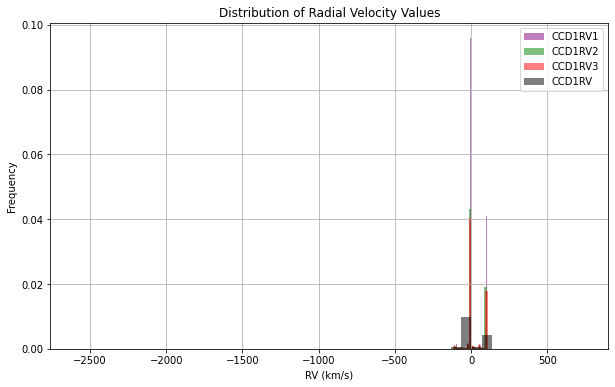

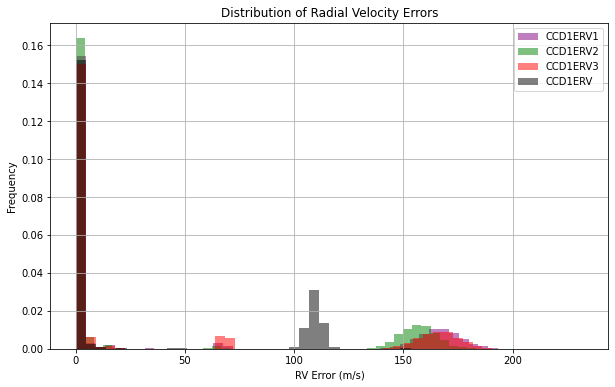

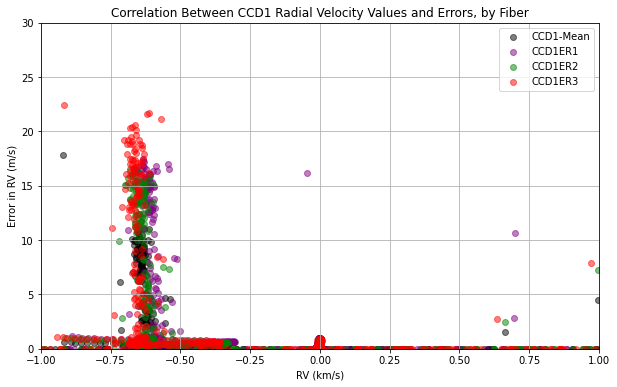

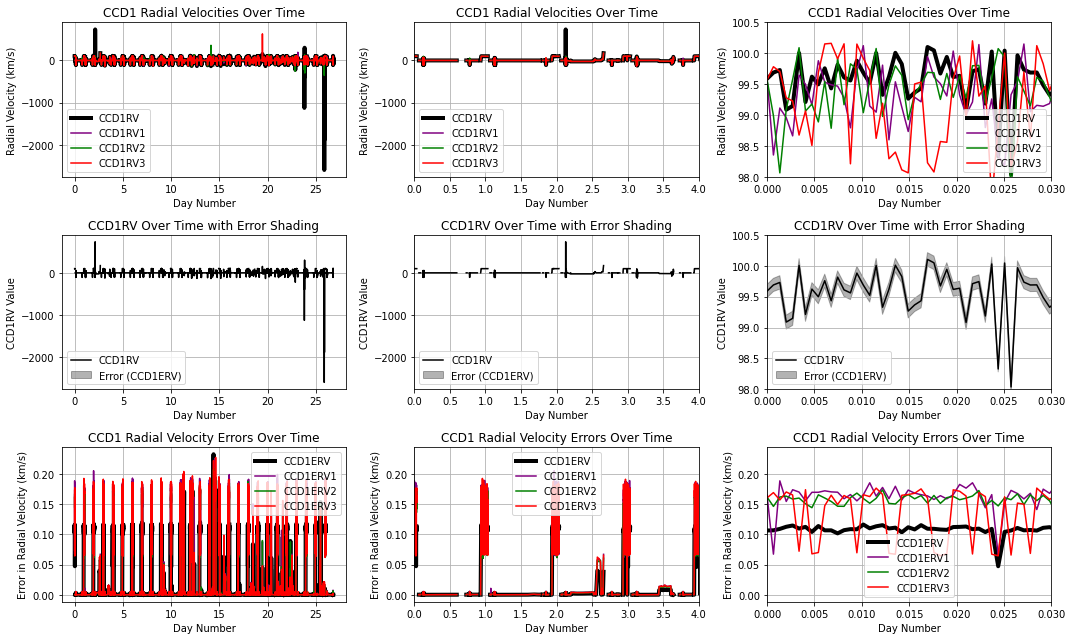

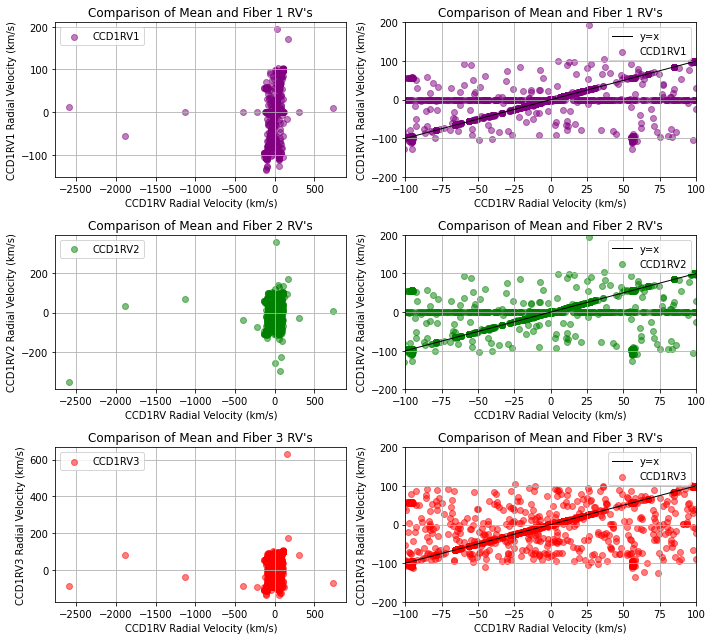

In [23]:
# plot the distributions of radial velocity values
plot_rv_value_histograms_by_fiber(df_02a)

# plot the distributions of radial velocity errors
plot_rv_error_histograms_by_fiber(df_02a)
# OBSERVATIONS:
#   the overall error is less than the error of each fiber (as expected)
#   the error distributions are different for the different fibers

# plot scatter of RV values and errors to explore possible correlations
plot_rv_error_scatter_by_fiber(df_02a, xmin=-1, xmax=1, ymin=0, ymax=30)
# OBSERVATIONS:
#   there is some clustering in the error 

# plot the mean RV value, along with its error, from the Green CCD over time
plot_rv_time_trends_grid(df_02a, 0, 0.03, 98, 100.5)
# OBSERVATIONS:
#   the error in RV varies over time (not a surprise)
# QUESTIONS:
#   how is the error itself computed?

# plot the mean RV against the component RV's
plot_rv_scatter_by_fiber(df_02a)
# OBSERVATIONS:
#   i'd naively expect a uniform distribution about y=x but we don't see this
#   howard mentioned that the error distribution around CCD1RV1=0 arises from the bias

### EDA - CCD1 - Etalon

In [24]:
# pass only objects that are etalon
df_02b= df_02a[df_02a['OBJECT'].str.contains('autocal-etalon')] # autocal-lfc # autocal-etalon

# inspect the df
display(df_02b.sample(3))

# display the df shape
print(f"DataFrame Shape: {df_02b.shape}")

ObsID                    OBJECT  datecode       CCD1BJD  \
13160  KP.20241024.66767.89   autocal-etalon-all-morn  20241024  2.460608e+06   
6921   KP.20241013.57767.15   autocal-etalon-all-morn  20241013  2.460597e+06   
1849   KP.20241004.22303.94  autocal-etalon-all-night  20241004  2.460588e+06   

         day_num  NOTJUNK GOODREAD EMSAT EMNEG  LOWBIAS  ...  kpfcal.IRFLUX  \
13160  23.772028      1.0     None  None  None      NaN  ...        4062.98   
6921   12.668353      1.0     None  None  None      NaN  ...        3820.52   
1849    3.254289      1.0     None  None  None      NaN  ...        4140.64   

       kpfcal.VISFLUX  kpfcal.BLUECUTIACT  kpfmot.AGITSPD  kpfmot.AGITTOR  \
13160        -15.2069            0.033172        -3836.90       -0.998103   
6921         -14.7414            0.033000        -3840.83       -1.090640   
1849         -14.3966            0.033000        -3847.14       -1.052140   

      kpfmot.AGITAMBI_T kpfmot.AGITMOT_T kpfpower.OUTLET_A1_Amps  \
13160           25.9197         0.301034                 49.0345   
6921            25.9307         0.302931                 48.5172   
1849            25.9345         0.298448                 49.1034   

       CCD1RV_upper  CCD1RV_lower  
13160     -0.006819     -0.007031  
6921      -0.006039     -0.006248  
1849      -0.005610     -0.005807  

[3 rows x 184 columns]

DataFrame Shape: (2538, 184)


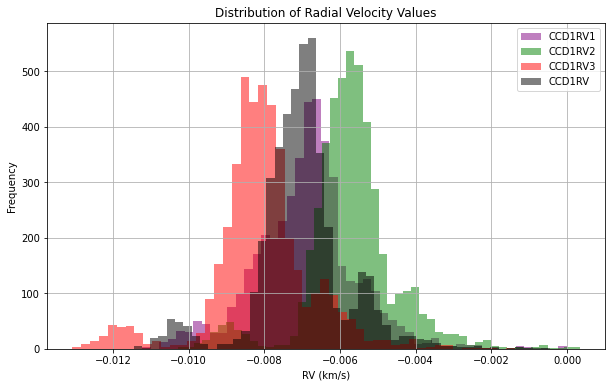

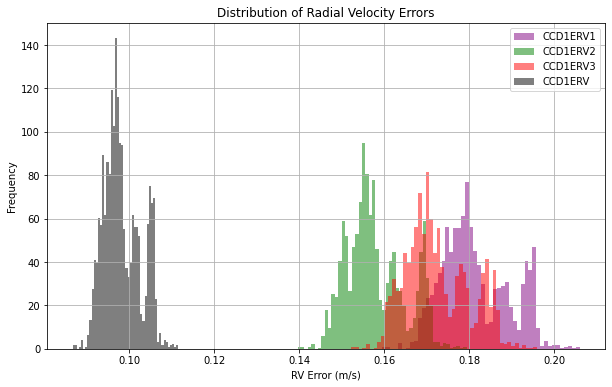

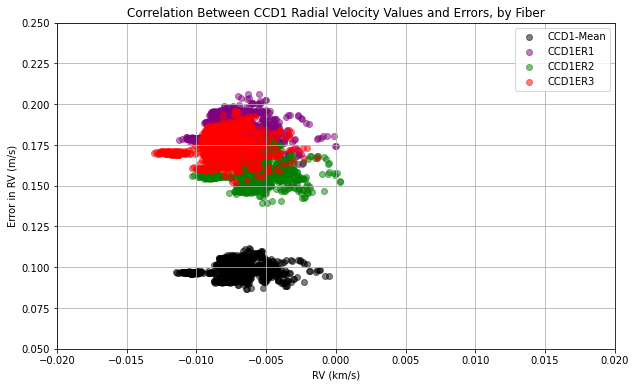

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


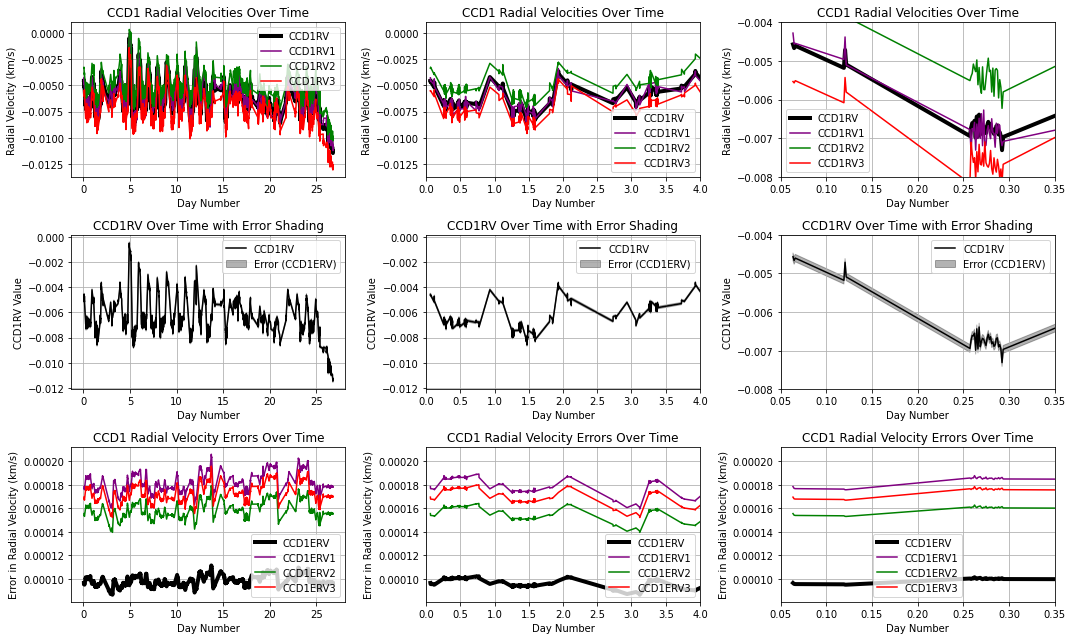

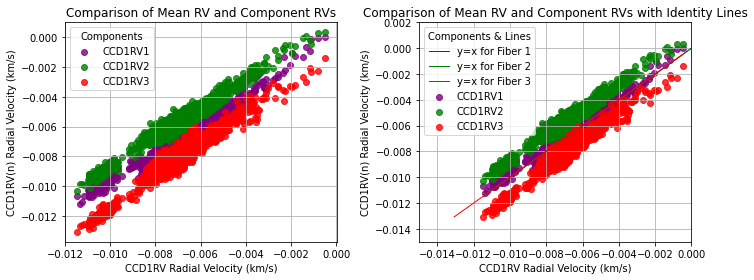

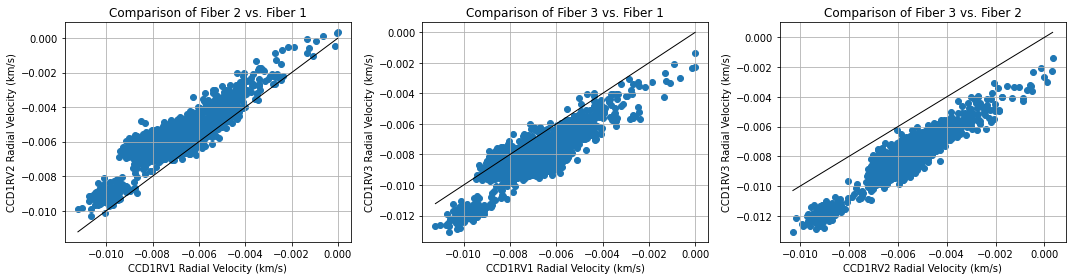

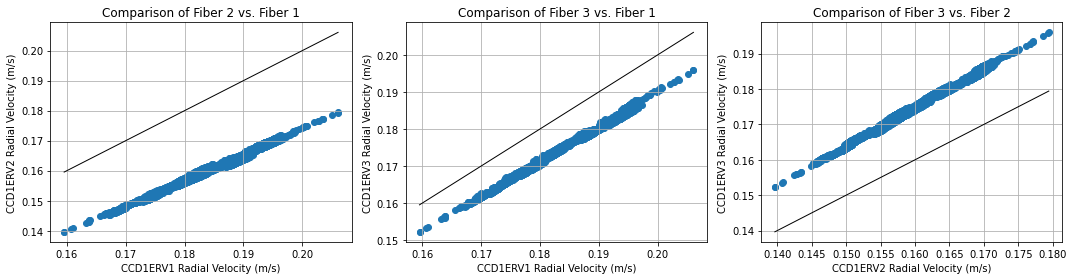

In [25]:
# plot the distributions of radial velocity values
plot_rv_value_histograms_by_fiber(df_02b)
# OBSERVATIONS:
#   why aren't the RV's centered about 0?

# plot the distributions of radial velocity errors
plot_rv_error_histograms_by_fiber(df_02b)
# OBSERVATIONS:
#   the overall error is ~ 0.1m/s, which is desired
#   the shape of the error distribution is not gaussian

# plot the distributions of radial velocity errors
plot_rv_error_scatter_by_fiber(df_02b, xmin=-.02, xmax=.02, ymin=0.05, ymax=.25)
# OBSERVATIONS:
#   there is some clustering in the error 

# investigate if there are any IQR outliers
"""show_iqr_outliers(df_02b, 'CCD1ERV')
show_iqr_outliers(df_02b, 'CCD1ERV1')
show_iqr_outliers(df_02b, 'CCD1ERV2')
show_iqr_outliers(df_02b, 'CCD1ERV3')"""

# perform t tests on errors from each error cluster
"""compare_rv_clusters_ttest(df_02b, 'CCD1ERV', 0.00025, 'CCD1ERV')
compare_rv_clusters_ttest(df_02b, 'CCD1ERV1', 0.00025, 'CCD1ERV1')
compare_rv_clusters_ttest(df_02b, 'CCD1ERV2', 0.00025, 'CCD1ERV2')
compare_rv_clusters_ttest(df_02b, 'CCD1ERV3', 0.00025, 'CCD1ERV3')"""

# perform t tests on temp from each error cluster
"""compare_rv_clusters(df_02b, 'CCD1ERV', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02b, 'CCD1ERV1', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02b, 'CCD1ERV2', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02b, 'CCD1ERV3', 0.00025, 'ETAV1C1T')"""

# plot the mean RV value, along with its error, from the Green CCD over time
plot_rv_time_trends_grid(df_02b, 0.05, .35, -.008, -0.004)
# OBSERVATIONS:
#   the error in RV varies over time (not a surprise)
# QUESTIONS:
#   how is the error itself computed?

# plot the mean RV against the component RV's
#plot_rv_scatter_by_fiber(df_02b, -0.015,0,-0.015,0)
plot_rv_scatter_by_fiber_overlay(df_02b, -0.015,0,-0.015,0.002)
# OBSERVATIONS:
#   i'd naively expect a uniform distribution about y=x but we don't see this
#   howard mentioned that the error distribution around CCD1RV1=0 arises from the bias

# plot scatter of RV values between fibers
plot_fiber_rv_values_scatter(df_02b)
# OBSERVATIONS:
#   y-offset =/= 0

# plot scatter of RV errors between fibers
plot_fiber_rv_errors_scatter(df_02b)
# OBSERVATIONS:
#   y-offset =/= 0;  for Fiber1/Fiber2 the slope =/= 1

SNRSC452     SNRSC548     SNRSC652     SNRSC747     SNRSC852
count  2536.000000  2536.000000  2536.000000  2536.000000  2536.000000
mean    280.421265   725.260262   762.165954   817.490556   623.528907
std       6.110248    11.780166    14.718652    10.001071    15.733817
min     262.340000   696.571000   729.722000   796.330000   586.582000
25%     278.434750   718.027750   751.938750   810.357000   609.495500
50%     281.859500   725.856000   759.952000   816.881500   630.212500
75%     283.922000   730.794000   766.694000   822.392500   634.952000
max     296.069000   765.831000   808.046000   850.440000   653.426000

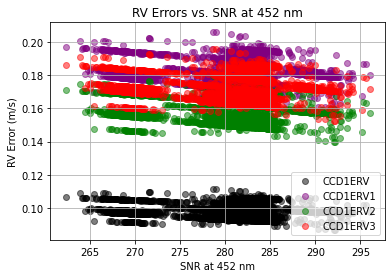

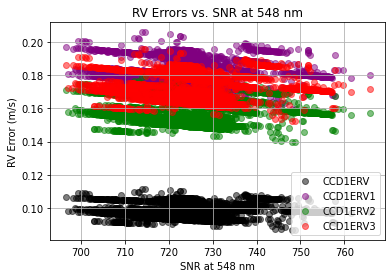

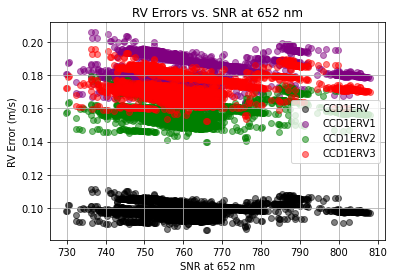

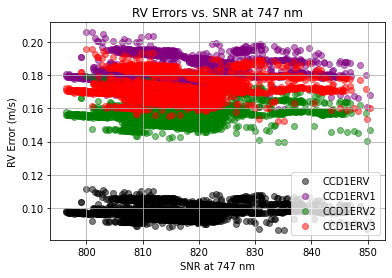

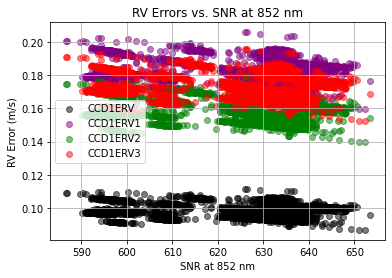

In [26]:
# inspect the SNR of the Science Fiber at 5 wavelengths
display(df_02b[['SNRSC452', 'SNRSC548', 'SNRSC652', 'SNRSC747', 'SNRSC852']].describe())

# plot the rv errors as a function of Science Fiber SNR for specified wavelengths
rv_error_cols = ['CCD1ERV', 'CCD1ERV1', 'CCD1ERV2', 'CCD1ERV3']
colors = ['black', 'purple', 'green', 'red']
plot_rv_errors_vs_snr_multiple(df_02b, 'SNRSC452', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02b, 'SNRSC548', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02b, 'SNRSC652', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02b, 'SNRSC747', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02b, 'SNRSC852', rv_error_cols, colors)

### EDA - CCD1 - LFC

In [27]:
# pass only objects that are lfc
df_02c= df_02a[df_02a['OBJECT'].str.contains('autocal-lfc')] # autocal-lfc # autocal-etalon

# inspect the df
display(df_02c.sample(3))

# display the df shape
print(f"DataFrame Shape: {df_02c.shape}")

ObsID                    OBJECT  datecode       CCD1BJD  \
13173  KP.20241024.68092.03      autocal-lfc-all-morn  20241024  2.460608e+06   
204    KP.20241001.34388.58  autocal-lfc-all-midnight  20241001  2.460585e+06   
12420  KP.20241023.11950.00       autocal-lfc-all-eve  20241023  2.460607e+06   

         day_num  NOTJUNK GOODREAD EMSAT EMNEG  LOWBIAS  ...  kpfcal.IRFLUX  \
13173  23.787353      1.0     None  None  None      NaN  ...         9999.0   
204     0.397203      1.0     None  None  None      NaN  ...         9999.0   
12420  22.137648      1.0     None  None  None      NaN  ...         9999.0   

       kpfcal.VISFLUX  kpfcal.BLUECUTIACT  kpfmot.AGITSPD  kpfmot.AGITTOR  \
13173         891.364             3.07864        -3942.09        -1.03949   
204           807.707             3.07897        -3867.78        -1.00419   
12420         879.250             3.07821        -3869.64        -1.01902   

      kpfmot.AGITAMBI_T kpfmot.AGITMOT_T kpfpower.OUTLET_A1_Amps  \
13173           25.9378         0.298909                 47.8727   
204             25.9524         0.300000                 49.4138   
12420           25.9425         0.300714                 48.4107   

       CCD1RV_upper  CCD1RV_lower  
13173      0.136825      0.136809  
204        0.136907      0.136889  
12420      0.136854      0.136840  

[3 rows x 184 columns]

DataFrame Shape: (578, 184)


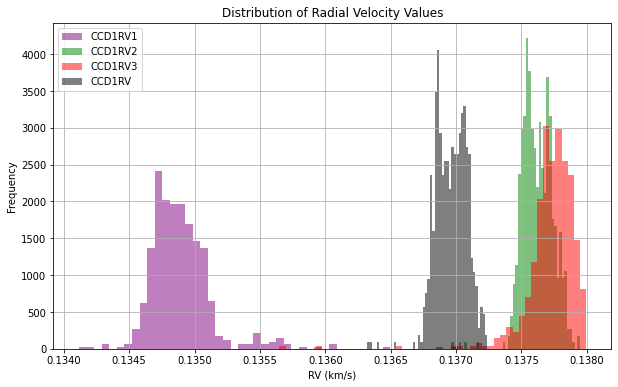

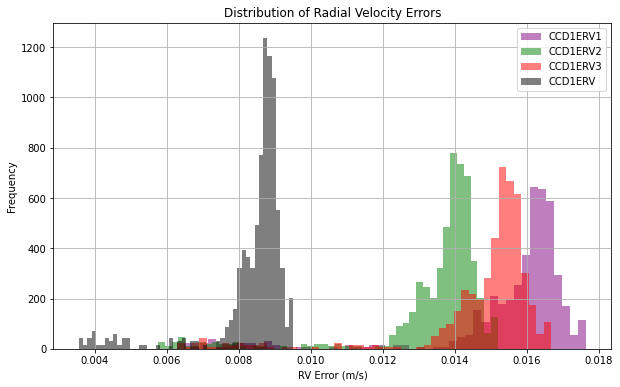

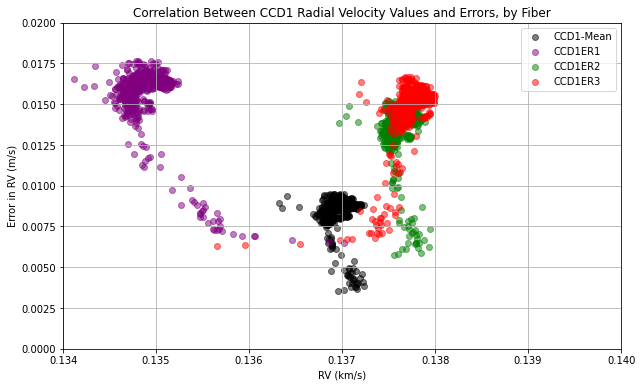

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


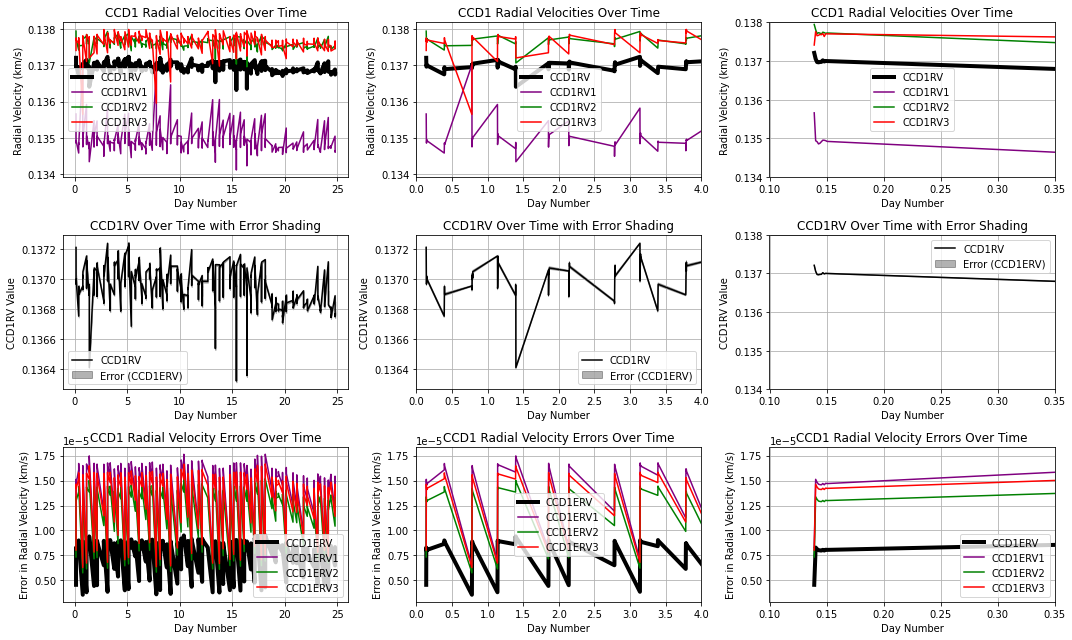

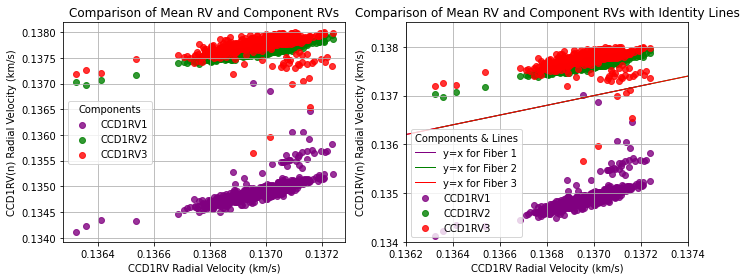

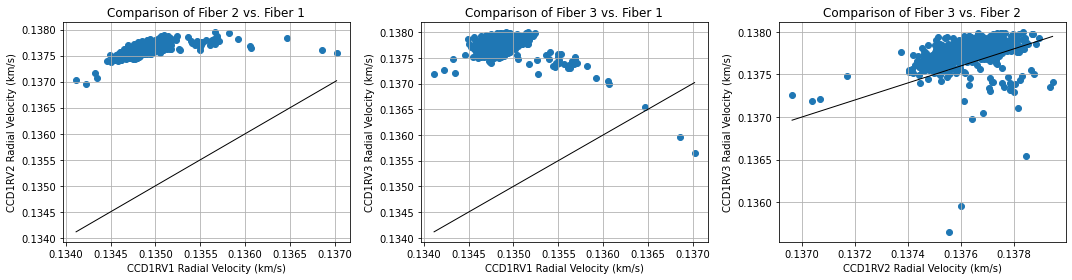

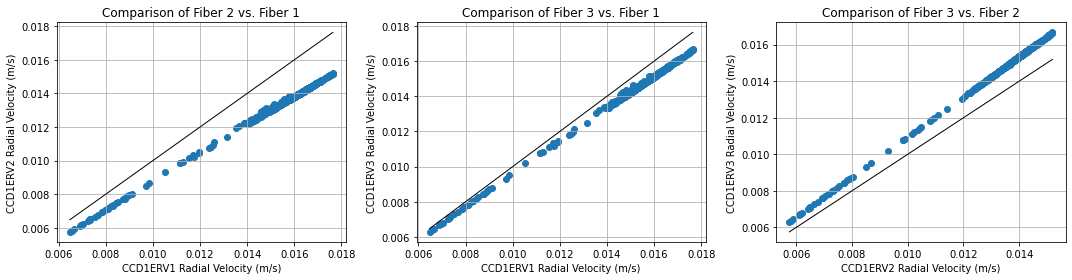

In [28]:
# plot the distributions of radial velocity values
plot_rv_value_histograms_by_fiber(df_02c)

# plot the distributions of radial velocity errors
plot_rv_error_histograms_by_fiber(df_02c)
# OBSERVATIONS:
#   why aren't the RV's centered around 0 (some neg, some pos)?

# plot the distributions of radial velocity errors
plot_rv_error_scatter_by_fiber(df_02c, xmin=.134, xmax=.14, ymin=0, ymax=.02)
# OBSERVATIONS:
#   there is some clustering in the error 

# investigate if there are any IQR outliers
"""show_iqr_outliers(df_02c, 'CCD1ERV')
show_iqr_outliers(df_02c, 'CCD1ERV1')
show_iqr_outliers(df_02c, 'CCD1ERV2')
show_iqr_outliers(df_02c, 'CCD1ERV3')"""

# perform t tests on errors from each error cluster
"""compare_rv_clusters_ttest(df_02c, 'CCD1ERV', 0.00025, 'CCD1ERV')
compare_rv_clusters_ttest(df_02c, 'CCD1ERV1', 0.00025, 'CCD1ERV1')
compare_rv_clusters_ttest(df_02c, 'CCD1ERV2', 0.00025, 'CCD1ERV2')
compare_rv_clusters_ttest(df_02c, 'CCD1ERV3', 0.00025, 'CCD1ERV3')"""

# perform t tests on temp from each error cluster
"""compare_rv_clusters(df_02c, 'CCD1ERV', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02c, 'CCD1ERV1', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02c, 'CCD1ERV2', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02c, 'CCD1ERV3', 0.00025, 'ETAV1C1T')"""

# plot the mean RV value, along with its error, from the Green CCD over time
plot_rv_time_trends_grid(df_02c, 0.1, .35, 0.134, 0.138)
# OBSERVATIONS:
#   the error in RV varies over time (not a surprise)
# QUESTIONS:
#   how is the error itself computed?

# plot the mean RV against the component RV's
#plot_rv_scatter_by_fiber(df_02c, 0.1362,0.1374,0.134,0.138)
plot_rv_scatter_by_fiber_overlay(df_02c, 0.1362,0.1374,0.134,0.1385)
# OBSERVATIONS:
#   i'd naively expect a uniform distribution about y=x but we don't see this
#   howard mentioned that the error distribution around CCD1RV1=0 arises from the bias

# plot scatter of RV values between fibers
plot_fiber_rv_values_scatter(df_02c)
# OBSERVATIONS:
#   y-offset =/= 0

# plot scatter of RV errors between fibers
plot_fiber_rv_errors_scatter(df_02c)
# OBSERVATIONS:
#   y-offset =/= 0;  for Fiber1/Fiber2 the slope =/= 1

SNRSC452     SNRSC548     SNRSC652     SNRSC747     SNRSC852
count  578.000000   578.000000   578.000000   578.000000   578.000000
mean   -20.472215  1144.393507  1133.367607  1033.447531   973.430074
std      3.633587   284.927782   156.706201    83.394312    43.222316
min    -41.852000   950.309000   993.286000   944.184000   919.921000
25%    -20.091250  1045.517250  1072.796750   996.765250   949.138750
50%    -19.611000  1077.142000  1093.695000  1010.027000   963.420000
75%    -19.198000  1111.268750  1117.275500  1028.768000   979.247000
max    -17.717000  2716.149000  1912.081000  1402.112000  1137.241000

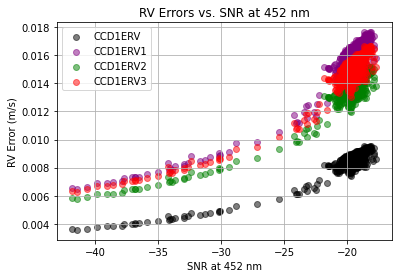

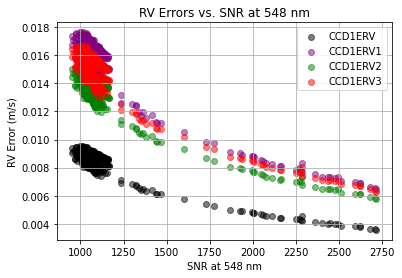

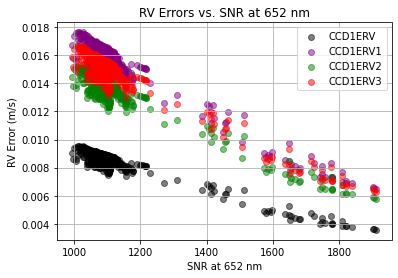

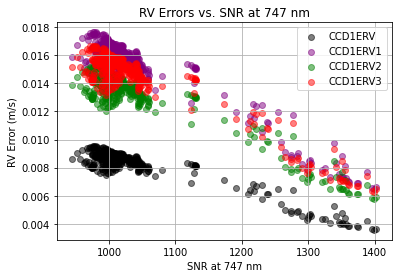

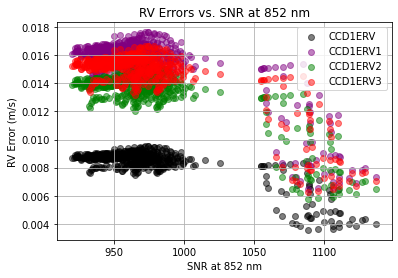

In [29]:
# inspect the SNR of the Science Fiber at 5 wavelengths
display(df_02c[['SNRSC452', 'SNRSC548', 'SNRSC652', 'SNRSC747', 'SNRSC852']].describe())

# plot the rv errors as a function of Science Fiber SNR for specified wavelengths
rv_error_cols = ['CCD1ERV', 'CCD1ERV1', 'CCD1ERV2', 'CCD1ERV3']
colors = ['black', 'purple', 'green', 'red']
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC452', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC548', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC652', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC747', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC852', rv_error_cols, colors)

In [30]:
# apply filter to keep data only in linear region with 
df_02c = df_02c[
    (df_02c['SNRSC452'] >= -22) &
    (df_02c['SNRSC548'] <= 1250) &
    (df_02c['SNRSC652'] <= 1250) &
    (df_02c['SNRSC747'] <= 1100) &
    (df_02c['SNRSC852'] <= 1025)
]

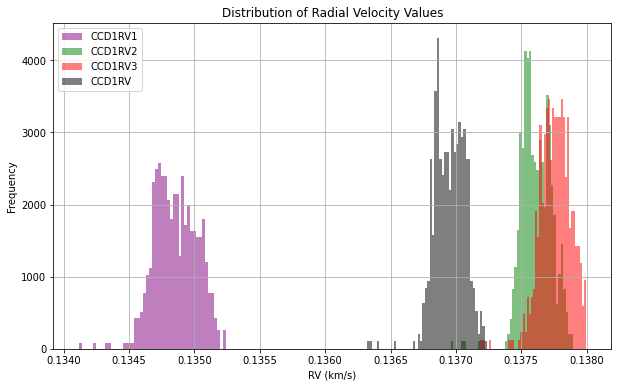

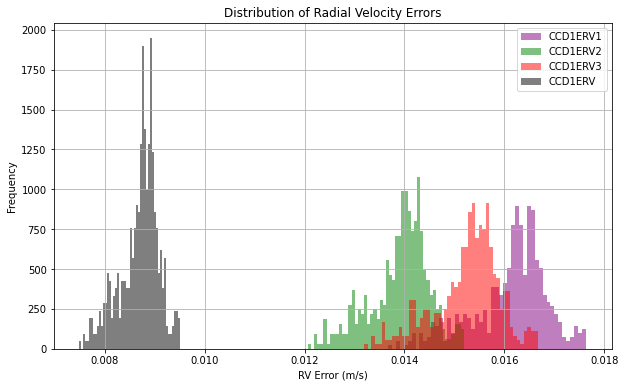

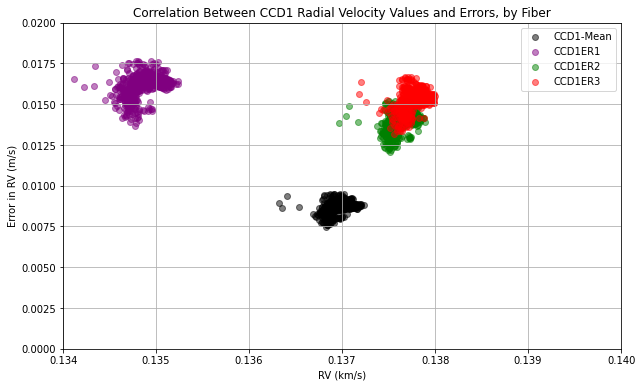

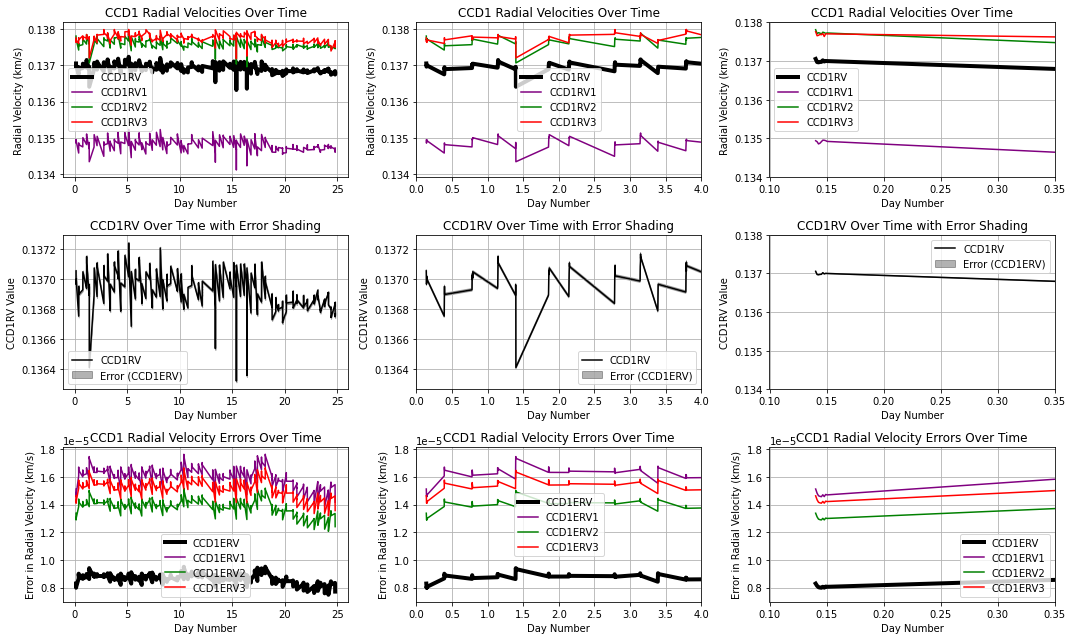

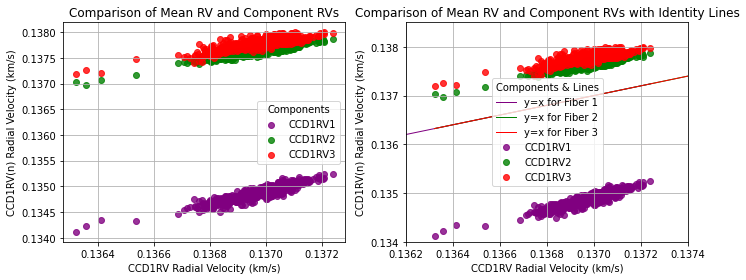

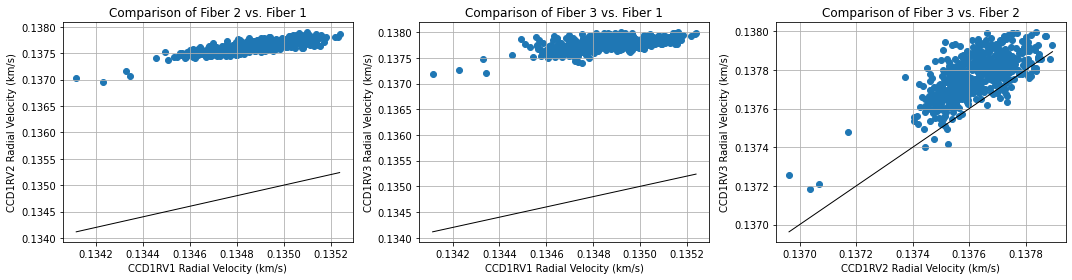

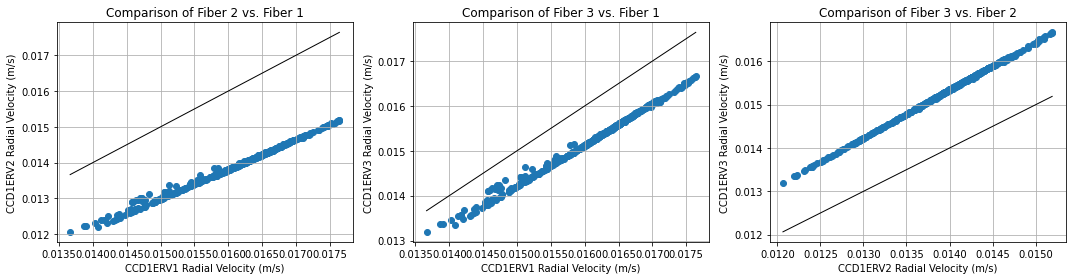

In [31]:
# plot the distributions of radial velocity values
plot_rv_value_histograms_by_fiber(df_02c)

# plot the distributions of radial velocity errors
plot_rv_error_histograms_by_fiber(df_02c)
# OBSERVATIONS:
#   why aren't the RV's centered around 0 (some neg, some pos)?

# plot the distributions of radial velocity errors
plot_rv_error_scatter_by_fiber(df_02c, xmin=.134, xmax=.14, ymin=0, ymax=.02)
# OBSERVATIONS:
#   there is some clustering in the error 

# investigate if there are any IQR outliers
"""show_iqr_outliers(df_02c, 'CCD1ERV')
show_iqr_outliers(df_02c, 'CCD1ERV1')
show_iqr_outliers(df_02c, 'CCD1ERV2')
show_iqr_outliers(df_02c, 'CCD1ERV3')"""

# perform t tests on errors from each error cluster
"""compare_rv_clusters_ttest(df_02c, 'CCD1ERV', 0.00025, 'CCD1ERV')
compare_rv_clusters_ttest(df_02c, 'CCD1ERV1', 0.00025, 'CCD1ERV1')
compare_rv_clusters_ttest(df_02c, 'CCD1ERV2', 0.00025, 'CCD1ERV2')
compare_rv_clusters_ttest(df_02c, 'CCD1ERV3', 0.00025, 'CCD1ERV3')"""

# perform t tests on temp from each error cluster
"""compare_rv_clusters(df_02c, 'CCD1ERV', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02c, 'CCD1ERV1', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02c, 'CCD1ERV2', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02c, 'CCD1ERV3', 0.00025, 'ETAV1C1T')"""

# plot the mean RV value, along with its error, from the Green CCD over time
plot_rv_time_trends_grid(df_02c, 0.1, .35, 0.134, 0.138)
# OBSERVATIONS:
#   the error in RV varies over time (not a surprise)
# QUESTIONS:
#   how is the error itself computed?

# plot the mean RV against the component RV's
#plot_rv_scatter_by_fiber(df_02c, 0.1362,0.1374,0.134,0.138)
plot_rv_scatter_by_fiber_overlay(df_02c, 0.1362,0.1374,0.134,0.1385)
# OBSERVATIONS:
#   i'd naively expect a uniform distribution about y=x but we don't see this
#   howard mentioned that the error distribution around CCD1RV1=0 arises from the bias

# plot scatter of RV values between fibers
plot_fiber_rv_values_scatter(df_02c)
# OBSERVATIONS:
#   y-offset =/= 0

# plot scatter of RV errors between fibers
plot_fiber_rv_errors_scatter(df_02c)
# OBSERVATIONS:
#   y-offset =/= 0;  for Fiber1/Fiber2 the slope =/= 1

SNRSC452     SNRSC548     SNRSC652     SNRSC747     SNRSC852
count  519.000000   519.000000   519.000000   519.000000   519.000000
mean   -19.515385  1069.833736  1088.213805  1008.184372   960.327266
std      0.598417    40.752306    31.942002    20.144567    18.458037
min    -20.988000   950.309000   993.286000   944.184000   919.921000
25%    -19.913000  1042.965500  1069.407500   995.351000   946.591500
50%    -19.527000  1072.130000  1089.544000  1007.107000   961.088000
75%    -19.151000  1100.042500  1107.832000  1019.778500   972.806000
max    -17.717000  1159.333000  1177.410000  1060.552000  1015.283000

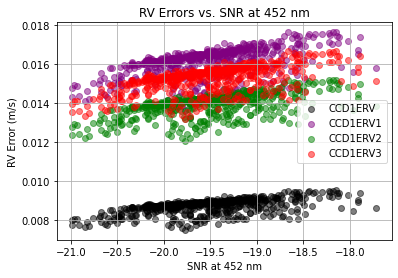

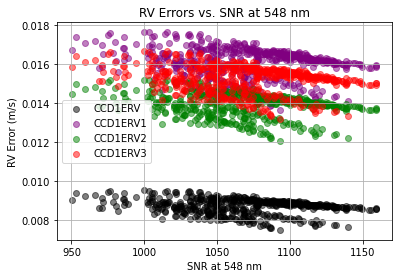

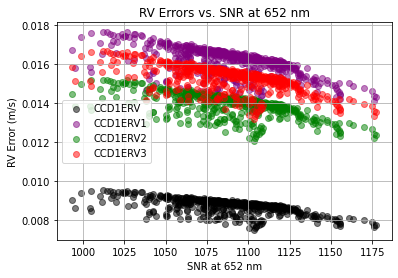

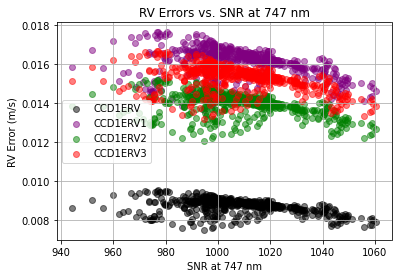

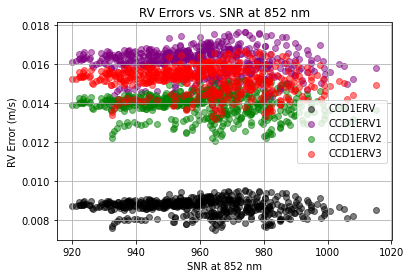

In [32]:
# inspect the SNR of the Science Fiber at 5 wavelengths
display(df_02c[['SNRSC452', 'SNRSC548', 'SNRSC652', 'SNRSC747', 'SNRSC852']].describe())

# plot the rv errors as a function of Science Fiber SNR for specified wavelengths
rv_error_cols = ['CCD1ERV', 'CCD1ERV1', 'CCD1ERV2', 'CCD1ERV3']
colors = ['black', 'purple', 'green', 'red']
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC452', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC548', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC652', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC747', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC852', rv_error_cols, colors)

## Provisional

### Correlation Mapping

### Plotly Plots

In [33]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [34]:
import plotly.express as px
import plotly.graph_objects as go

# create a scatter plot of RV values and RV errors, for each fiber in CCD1, using plotly
def plot_rv_error_scatter_by_fiber(df, xmin, xmax, ymin, ymax, hover_details=['ObsID', 'OBJECT', 'day_num']):

    fig = go.Figure()

    # make a plot for each fiber with hover data
    for fiber, color, name in zip(['CCD1RV', 'CCD1RV1', 'CCD1RV2', 'CCD1RV3'],
                                  ['black', 'purple', 'green', 'red'],
                                  ['CCD1-Mean', 'CCD1ER1', 'CCD1ER2', 'CCD1ER3']):
        fig.add_trace(go.Scatter(
            x=df[fiber],
            y=df[f"{fiber.replace('RV', 'ERV')}"] * 1000,  # Convert to m/s
            mode='markers',
            marker=dict(color=color),
            name=name,
            text=df[hover_details].astype(str).agg(', '.join, axis=1),
            hoverinfo='text+x+y'
        ))

    # update the layout to set the axis limits and labels
    fig.update_layout(
        title='Correlation Between CCD1 Radial Velocity Values and Errors, by Fiber',
        xaxis=dict(title='RV (km/s)', range=[xmin, xmax]),
        yaxis=dict(title='Error in RV (m/s)', range=[ymin, ymax]),
        legend_title="Fibers",
        hovermode='closest'
    )

    fig.show()

In [38]:
plot_rv_error_scatter_by_fiber(df_02b, xmin=-.02, xmax=.01, ymin=0.05, ymax=.25)

### Folded plots (period specification)

In [36]:
# define a function to ovrlay all cycles, over a given period, for a specified feature
def plot_time_folds(df, col_name, period=1):  # Default period set to 1 day
    
    # make a scatter plot of feature over time
    plt.figure(figsize=(12, 4))
    plt.scatter(df['day_num'], df[col_name], alpha=0.6)
    plt.title(f"Scatter Plot of {col_name} vs Day Number")
    plt.xlabel('Day Number')
    plt.ylabel(col_name)
    plt.grid(True)
    plt.show()
    
    # make a phase folded scatter plot of the feature over a given period
    # compute the phase using the specified period
    phase = (df['day_num'] % period) / period
    cycles = (df['day_num'] // period).astype(int)  # determine which cycle each point belongs to
    plt.figure(figsize=(12, 4))
    # make a scatter plot with each cycle in a different color
    scatter = plt.scatter(phase * period, df[col_name], c=cycles, cmap='plasma', alpha=0.6)
    plt.colorbar(scatter, label='Cycle Number')
    plt.title(f"Phase-Folded Plot for Period: {period} days")
    plt.xlabel(f'Time within Period ({period} days)')
    plt.ylabel(col_name)
    plt.grid(True)
    plt.show()

In [37]:
plot_time_decomposition(df_02b, 'kpfmet.CAL_BENCH_BB_SRC') # Cal bench blackbody source temp

NameError: name 'plot_time_decomposition' is not defined

### Folded plots (period decomposition)

In [ ]:
from scipy.signal import periodogram

# define a function to ovrlay all cycles, over the highest-power periods, for a specified feature
def plot_time_decomposition(df, col_name):

    # data cleaning: need to drop rows where 'day_num' or 'col_name' is NaN or infinite
    df = df.dropna(subset=['day_num', col_name])
    df = df[np.isfinite(df['day_num']) & np.isfinite(df[col_name])]

    # make a scatter plot of feature over time
    plt.figure(figsize=(12, 4))
    plt.scatter(df['day_num'], df[col_name], alpha=0.6)
    plt.title(f"Scatter Plot of {col_name} vs Day Number")
    plt.xlabel('Day Number')
    plt.ylabel(col_name)
    plt.grid(True)
    plt.show()

    # apply fourier analysis, generate a periodogram, and annotate top-3 peaks
    fs = 1 / (df['day_num'].diff().median())  # compute sampling frequency in cycles/day
    frequencies, powers = periodogram(df[col_name], fs=fs)
    plt.figure(figsize=(12, 4))
    plt.semilogy(frequencies, powers)
    plt.title('Fourier Transform')
    plt.xlabel('Frequency (cycles/day)')
    plt.ylabel('Power')
    plt.xlim(0,100)
    # highlight the top 3 peaks
    top_freqs = frequencies[np.argsort(powers)[-3:]]
    for freq in top_freqs:
        plt.annotate(f'{freq:.4f}', xy=(freq, max(powers)), arrowprops=dict(arrowstyle='->'))
    plt.grid(True)
    plt.show()

    # make the pase-folded plots for top-3 frequencies
    for freq in top_freqs:
        period = 1 / freq
        phase = (df['day_num'] % period) / period
        cycles = (df['day_num'] // period).astype(int)  # determine which cycle each point belongs to
        plt.figure(figsize=(12, 4))
        scatter = plt.scatter(phase * period, df[col_name], c=cycles, cmap='viridis', alpha=0.6)  # using colormap 'viridis'
        plt.colorbar(scatter, label='Cycle Number')
        plt.title(f'Phase Folded Plot at Period: {period:.4f} days')
        plt.xlabel('Phase [days]')
        plt.ylabel(col_name)
        plt.grid(True)
        plt.show()

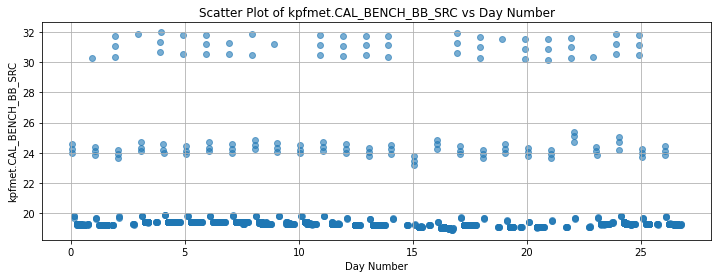

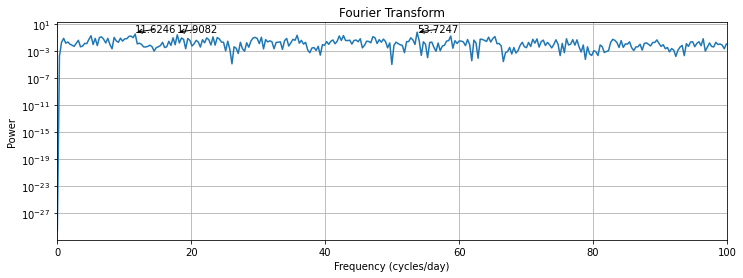

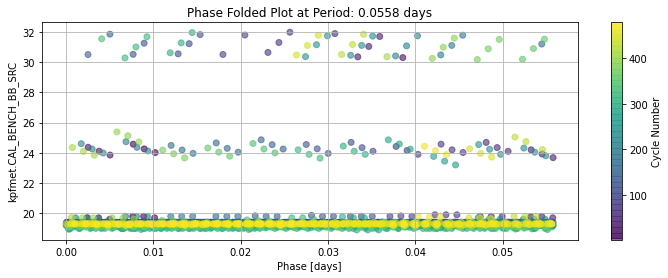

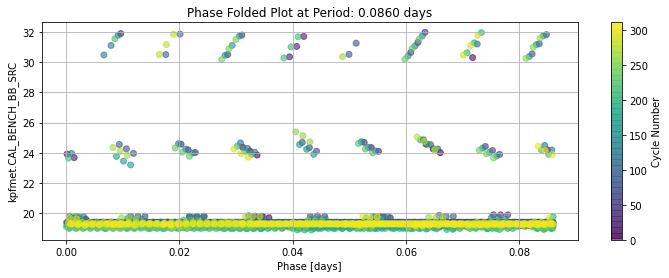

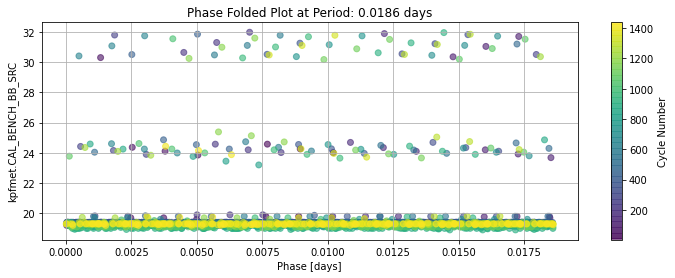

In [ ]:
plot_time_decomposition(df_02b, 'kpfmet.CAL_BENCH_BB_SRC') # Cal bench blackbody source temp